In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
from torch.autograd import Variable
import torch.nn.functional as F 

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
torch.cuda.is_available()

True

In [7]:
# *GPU 사용
## 하나의 GPU 사용 시
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = Net()
# model.to(device)

## 다수의 GPU 사용 시 nn.DataParallel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net()
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(net)
model.to(device)

## nn.DataParallel을 사용할 경우 batch size가 알아서 각 GPU로 분배되는 방식으로 작동. 따라서 GPU 수만큼 배치 크기도 늘려주어야 함.



NameError: name 'Net' is not defined

In [8]:
train_dataset = torchvision.datasets.FashionMNIST("/home/hb/python/pytorch_book/080289/chap05/data", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("/home/hb/python/pytorch_book/080289/chap05/data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /home/hb/python/pytorch_book/080289/chap05/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/hb/python/pytorch_book/080289/chap05/data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /home/hb/python/pytorch_book/080289/chap05/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/hb/python/pytorch_book/080289/chap05/data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /home/hb/python/pytorch_book/080289/chap05/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/hb/python/pytorch_book/080289/chap05/data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /home/hb/python/pytorch_book/080289/chap05/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/hb/python/pytorch_book/080289/chap05/data/FashionMNIST/raw



In [9]:
test_dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /home/hb/python/pytorch_book/080289/chap05/data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [33]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

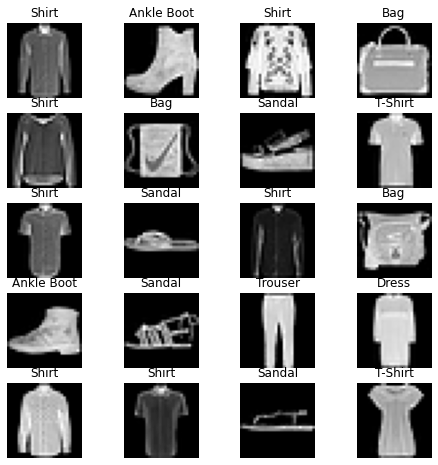

In [34]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8));
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

In [35]:
class FashionDNN(nn.Module):
    def __init__(self): # 1
        super(FashionDNN,self).__init__()
        self.fc1 = nn.Linear(in_features=784,out_features=256) # 2
        self.drop = nn.Dropout2d(0.25) # 3
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=10)

    def forward(self,input_data): # 4
        out = input_data.view(-1, 784) # 5
        out = F.relu(self.fc1(out)) # 6
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

1. class 형태의 모델은 항상 `torch.nn.Module` 을 상속받습니다. `__init__()`은 객체가 갖는 속성 값을 초기화하는 역할을 하며, 객체가 생성될 때 자동으로 호출됩니다. `super(FashionDNN, self).__init__()`은 FashionDNN이라는 부모(super) 클래스를 상속받겠다는 의미로 이해하면 됩니다.

2. nn은 딥러닝 모델(네트워크) 구성에 필요한 모듈이 모여 있는 패키지이며, Linear는 단순 선형 회귀 모델을 만들 때 사용합니다. 이때 사용되는 파라미터는 다음과 같습니다.
- `nn.Linear(in_features=784, out_features=256)`
    - in_features : 입력의 크기(input size)
    - out_features : 출력의 크기(output size)
실제로 데이터 연산이 진행되는 `forward()` 부분에는 첫 번째 파라미터 값만 넘겨주게 되며, 두 번째 파라미터에서 정의된 크기가 `forward()` 연산의 결과가 됩니다.

3. `torch.nn.Dropout(p)`는 p만큼의 비율로 텐서의 값이 0이 되고, 0이 되지 않는 값들은 기존 값에 (1/(1-p))만큼 곱해져 커집니다. 예를 들어 p=0.3 이라는 의미는 전체 값 중 0.3의 확률로 0이 된다는 것이며, 0이 되지 않는 0.7에 해당하는 값은 (1/(1-0.7))만큼 커집니다.

4. `forward()` 함수는 모델이 학습 데이터를 입력받아서 순전파(forward propagation) 학습을 진행시키며, 반드시 forward라는 이름의 함수여야 합니다. 즉, `forward()` 는 모델이 학습 데이터를 입력받아서 순전파 연산을 진행하는 함수이며, 객체를 데이터와 함께 호출하면 자동으로 실행됩니다. 이때 순전파 연산이란 H(x)^2 식에 입력 x로부터 예측된 y를 얻는 것입니다.

5. 파이토치에서 사용하는 뷰(`view`)는 넘파이의 `reshape` 과 같은 역할로 텐서의 크기(shape)를 변경해 주는 역할을 합니다. 따라서 `input_data.view(-1, 784)`는 input_data를 (?, 784)의 크기로 변경하라는 의미입니다. 이때 첫 번째 차원(-1)은 사용자가 잘 모르겠으니 파이토치에 맡기겠다는 의미이고, 두 번째 차원의 길이는 784를 가지도록 하라는 의미입니다. 다시 말해 2차원 텐서로 변경하되 (?, 84)의 크기로 변경하라는 의미입니다.

6. 활성화 함수를 지정할 때는 다음 두 가지 방법이 가능합니다.
- `F.relu()`: `forward()` 함수에서 정의
- `nn.ReLU()`: `__init__()` 함수에서 정의

활성화 함수 사용에 한정하여 이 둘 간의 차이는 간단히 사용하는 위치라고 할 수 있습니다. 하지만 근본적으로는 `nn.functional.xx()` (혹은 `F.xx()`)와 `nn.xx()`는 사용 방법에 차이가 있습니다. 다음 코드를 통해 둘 간의 차이를 확인할 수 있습니다.

먼저 `nn`을 사용하는 코드는 다음과 같습니다.

In [30]:
import torch
import torch.nn as nn

inputs = torch.randn(64, 3, 244, 244)
conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
outputs = conv(inputs)
layer = nn.Conv2d(1,1,3)
print(outputs)
print(layer)

tensor([[[[-3.9179e-01, -6.6180e-01,  6.2080e-01,  ...,  5.4166e-02,
            3.1774e-01,  4.7330e-01],
          [-2.6576e-01, -4.3539e-01,  6.3349e-01,  ..., -6.2149e-01,
           -1.0387e+00, -3.8742e-01],
          [ 5.5097e-01, -3.5564e-01, -6.2349e-01,  ..., -2.5642e-01,
            4.7172e-01, -7.2175e-01],
          ...,
          [-6.8583e-01,  1.1937e+00, -8.7824e-01,  ...,  9.8430e-02,
           -3.5896e-01,  4.4771e-02],
          [ 4.8480e-01, -1.1513e+00,  4.5179e-01,  ...,  5.3715e-01,
           -5.4504e-01,  2.7506e-01],
          [ 7.4334e-02,  2.7508e-01,  1.4446e-02,  ..., -5.1243e-01,
            4.1997e-01, -9.7514e-01]],

         [[ 4.1706e-01,  5.6596e-01, -6.6667e-02,  ...,  1.7842e+00,
            7.4719e-01, -5.4120e-01],
          [ 1.9432e-01,  5.5281e-01, -7.9650e-01,  ..., -4.8684e-01,
           -3.4257e-01, -2.3254e-01],
          [-3.9433e-01,  2.5429e-01, -1.7076e-02,  ...,  2.0659e-01,
            1.1264e+00, -2.5525e-02],
          ...,
     

In [31]:
import torch.nn.functional as F 

inputs = torch.randn(64, 3, 244, 244)
weight = torch.randn(64, 3, 3 , 3)
bias = torch.randn(64)
outputs = F.conv2d(inputs, weight, bias, padding=1)


In [36]:
# 5-7 : 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)
